In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

from numpy.polynomial.hermite import hermgauss

import scipy.cluster.hierarchy as sch

import paragami

from copy import deepcopy

# regression-mixture libraries
from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils

# BNP libraries
from bnpmodeling_runjingdev import result_loading_utils
from bnpmodeling_runjingdev import influence_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
from bnpmodeling_runjingdev.sensitivity_lib import get_cross_hess

import matplotlib.pyplot as plt
%matplotlib inline

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp

# Load data

In [3]:
g_obs = data_utils.load_thrush_data()[0]

print(g_obs.shape)

n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]


loading thrush data from : 
../data/thrush_data/thrush-data.str
(155, 7, 2, 21)


# Load fits

In [7]:
out_folder = '../fits/thrush_fits/'
out_filename = 'thrush_fit'
alpha0 = 3.0

In [8]:
fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'

In [10]:
print('loading fit from ', fit_file)
vb_init_dict, vb_params_paragami, \
    prior_params_dict, prior_params_paragami, \
        gh_loc, gh_weights, meta_data = \
            structure_model_lib.load_structure_fit(fit_file)

vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)


loading fit from  ../fits/thrush_fits/thrush_fit_alpha3.0.npz


In [11]:
print(vb_params_paragami)

OrderedDict:
	[pop_freq_dirichlet_params] = NumericArrayPattern (20, 7, 21) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (155, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (155, 19) (lb=0.0, ub=inf)


# Load influence results

In [12]:
influence_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_infl_funcs.npz'

print(influence_file) 

influence_results = np.load(influence_file)

../fits/thrush_fits/thrush_fit_alpha3.0_infl_funcs.npz


In [13]:
# check that things in the influence file match things in my fit file
assert np.all(influence_results['vb_opt'] == vb_init_free)
assert np.abs(influence_results['kl'] - meta_data['final_kl']) < 1e-10

# Define posterior quantity

In [14]:
# seed that was saved in computing the influence functions
prng_key = jax.random.PRNGKey(influence_results['seed'])

threshold = 0

@jax.jit
def get_e_num_clusters(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs,
                                                       vb_params_dict,
                                                       gh_loc, gh_weights,
                                                       threshold = 0,
                                                       n_samples = 1000, 
                                                       prng_key = prng_key)

@jax.jit
def get_e_num_clusters_pred(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.\
            get_e_num_pred_clusters(vb_params_dict,
                                    gh_loc,
                                    gh_weights, 
                                    n_samples = 1000,
                                    threshold = 0, 
                                    prng_key = prng_key,
                                    return_samples = False)


# Plot influence function

In [15]:
logit_v_grid = influence_results['logit_v_grid']

In [16]:
# the prior (for plotting)
def p0(logit_v, alpha0): 
    return np.exp(influence_lib.get_log_logitstick_prior(logit_v, alpha0))

In [17]:
# function to get worst-case log-phi
def get_wc_log_phi_grid(influence_grid): 
    # returns log_phi at points logit_v_grid
    # just for plotting
    
    worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                    logit_v_grid = logit_v_grid, 
                                                    delta = 1.,
                                                    cached_influence_grid = influence_grid)

    return worst_case.log_phi(logit_v_grid), worst_case.change_points


In [18]:
def plot_influence_grid(influence_grid, influence_grid_x_prior, ax): 
    
    # plot y = 0 line
    for i in range(4): 
        ax[i].axhline(0, color = 'black')
    
    # plot influence function
    ax[0].plot(logit_v_grid, influence_grid, color = '#43a2ca')
    
    # plot prior
    ax[1].plot(logit_v_grid, p0(logit_v_grid, alpha0), 
                  color = '#7bccc4')
    
    # plot influence x prior
    ax[2].plot(logit_v_grid, influence_grid_x_prior, color = '#0868ac')
    
    # plot l-inf worst-case perturbation
    wc_log_phi, change_points = get_wc_log_phi_grid(influence_grid)
    ax[3].plot(logit_v_grid, wc_log_phi, color = 'grey')
    ax[3].fill_between(logit_v_grid, 0, wc_log_phi, color = 'grey', alpha = 0.5)
    
    for cp in change_points: 
        ax[2].axvline(cp, color = 'grey', linestyle = 'dashed')
    
    ax[0].set_ylabel('influence')
    ax[1].set_ylabel('prior')
    ax[2].set_ylabel('influence x prior')
    ax[3].set_ylabel('worst-case log phi')


### Influence on cluster allocations

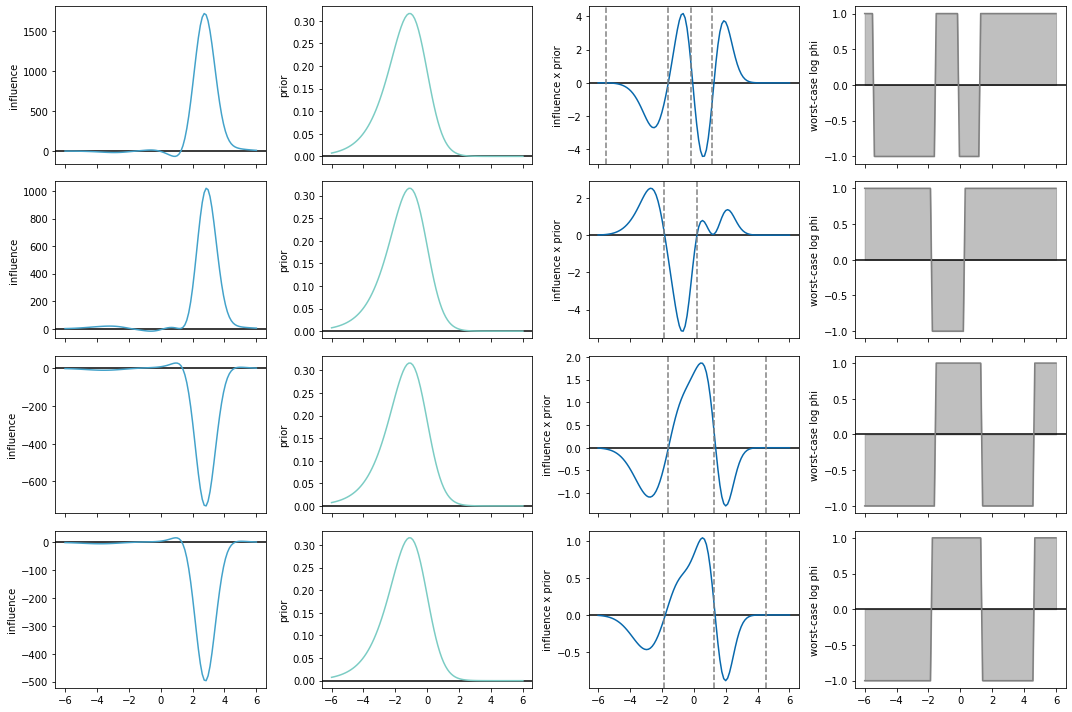

In [19]:
fig, axarr = plt.subplots(4, 4, figsize = (15, 10),  sharex = True) 

for k in range(4): 
    plot_influence_grid(influence_results['e_num_ind{}_infl'.format(k)], 
                        influence_results['e_num_ind{}_infl_x_prior'.format(k)],
                        axarr[k])
    
fig.tight_layout()

### On expected number of clusters

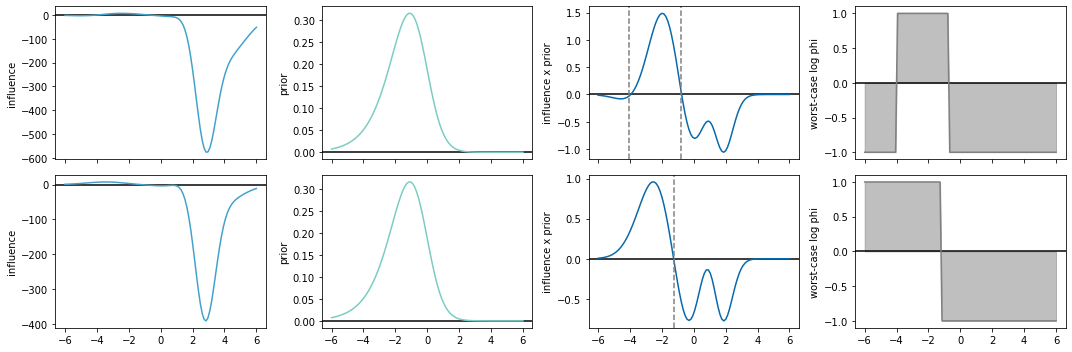

In [21]:
fig, axarr = plt.subplots(2, 4, figsize = (15, 5),  sharex = True) 

plot_influence_grid(influence_results['num_clust_infl'], 
                    influence_results['num_clust_infl_x_prior'],
                    axarr[0])

plot_influence_grid(influence_results['num_clust_pred_infl'], 
                    influence_results['num_clust_pred_infl_x_prior'],
                    axarr[1])


fig.tight_layout()

# Function to load refitted vb parameters

In [22]:
def load_refit_results(g, g_name): 
    match_crit = out_filename + '_' + g_name + '_wc_eps' + '\d+.npz'
    
    # load free parameters
    vb_refit_list, epsilon_vec, meta_data_list = \
        result_loading_utils.load_refit_files_epsilon(out_folder, match_crit)
    
    g_refit_list = np.array([g(x) for x in vb_refit_list])
    
    return g_refit_list, vb_refit_list, epsilon_vec

# Function to get LR results

In [23]:
def get_lr_results(g, g_name, epsilon_vec): 
    # get cross-hessian 
    cross_hess = influence_results[g_name + '_wc_cross_hess']
    
    # gradient of g times hessian 
    ghess = influence_results[g_name + '_ghess']
    
    # get derivative 
    dg_dhyper = np.dot(ghess, -cross_hess)
    
    # get lr results
    lr_g_array = g(vb_init_free) + dg_dhyper * epsilon_vec
    
    return lr_g_array


# Function to plot results

In [24]:
def plot_results(g, g_name): 
    
    fig, ax = plt.subplots(1, 4, figsize = (14, 3.5))
    
    # load refit and lr posterior statistic
    refit_g_vec, vb_refit_list, epsilon_vec = load_refit_results(g, g_name)
    lr_g_vec = get_lr_results(g, g_name, epsilon_vec)
    
    # define worst-case log phi
    worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                    logit_v_grid = logit_v_grid, 
                                                    delta = 1.,
                                                    cached_influence_grid = influence_results[g_name + '_infl'])
    
    ###################
    # plot prior x influence function 
    ###################
    influence_x_prior_grid = influence_results[g_name + '_infl_x_prior']
    ax[0].plot(logit_v_grid, influence_x_prior_grid)
    
    # plot y = 0
    ax[0].axhline(0, color = 'black')

    # overlay bump
    ax[0].plot(logit_v_grid, 
               worst_case.log_phi(logit_v_grid),
               color = 'grey')

    ax[0].fill_between(logit_v_grid, 
                       0,
                       worst_case.log_phi(logit_v_grid),
                       color = 'grey',
                       alpha = 0.5)
    ax[0].set_ylim((influence_x_prior_grid.min() * 0.95, 
                     influence_x_prior_grid.max() * 1.05))
    ax[0].set_xlabel('influence x prior')

    ###################
    # plot perturbed prior 
    ###################
    # compute perturbed prior
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = alpha0,
                                log_phi = worst_case.log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

    prior_perturbation._plot_priors(ax[1])
    prior_perturbation._plot_priors_constrained(ax[2])
    ax[2].legend()

    for j in range(3): 
        ax[j].set_xlabel('logit-sticks')

    ###################
    # plot posterior statistic 
    ###################                        
    # plot refit results
    ax[3].plot(epsilon_vec,
                  refit_g_vec - refit_g_vec[0], 
                  '-o', 
                  label = 'refit')

    # plot lr results
    ax[3].plot(epsilon_vec, 
                  lr_g_vec - lr_g_vec[0], 
                  '-o', 
                  label = 'lr')

    ax[3].set_xlabel('epsilon')
    ax[3].axhline(0, color = 'black')

    ax[3].legend()
    ax[3].set_ylabel('g(pert) - g(init)')

    fig.tight_layout()


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.593216e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.598745e-01
  warnings.warn(


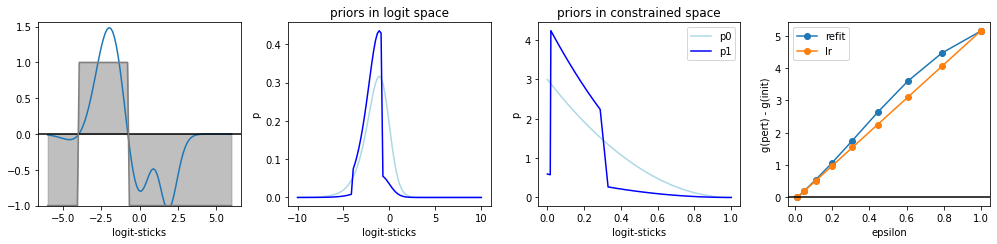

In [26]:
plot_results(get_e_num_clusters, 'num_clust');

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.430013e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.453286e-01
  warnings.warn(


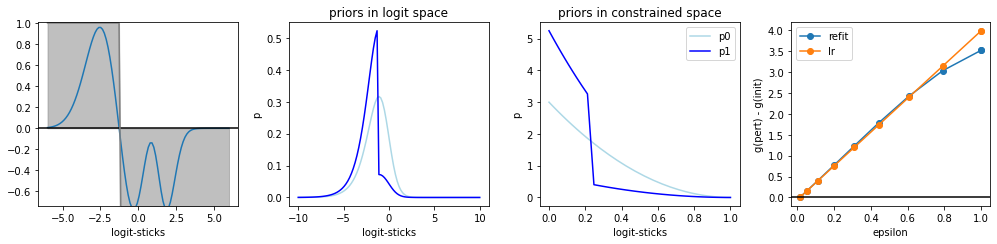

In [27]:
worst_case = plot_results(get_e_num_clusters_pred, 'num_clust_pred')